### Written by  [Gabriel Borges Pinheiro](github.com/gabrielbopi) & Wissam Melo

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

#### Creating the test environment

In [2]:
def bases(D, x, y, alt=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
            n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),alt])) 
        
    return total, n.reshape(total,3)

def usuário(n, x, y):
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random(),y*np.random.random(),1.5]))
    return UE.reshape(n,3)

In [3]:
def BSs_per_UE(BS, UE, total):
    endereços = []

    for n in range(num_ue):
        BS_UE = np.array([])
        conectadas = 0
        for i in range(total):
            dist = np.linalg.norm(BS[i]-UE[n])
            if dist <= 50:
                conectadas += 1
                BS_UE = np.append(BS_UE, BS[i])
        BS_UE = np.append(BS_UE, 0)
        endereços = np.append(endereços,BS_UE)
  
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(endereços) 
    idx_list = [idx + 1 for idx, val in enumerate(endereços) if val == 0] 
    res = [endereços[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    
    for i in range(len(res)):
        indices = np.where(res[i]==0)
        res[i] = np.delete(res[i], indices)
        res[i] = res[i].reshape(int((res[i].shape[0])/3),3)
    res = np.array(res)
    return res

In [4]:
def UEs_per_BS(BS, UE, total):
    positions = []

    for n in range(total):
        BS_UE = np.array([])
        conectados = 0
        for i in range(num_ue):
            dist = np.linalg.norm(BS[n]-UE[i])
            if dist <= 50:
                conectados += 1
                BS_UE = np.append(BS_UE, UE[i])
        BS_UE = np.append(BS_UE, 0)
        positions = np.append(positions,BS_UE)
    
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(positions) 
    idx_list = [idx + 1 for idx, val in enumerate(positions) if val == 0]
    antenna = [positions[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))] 

    for i in range(len(antenna)):
        indices = np.where(antenna[i]==0)
        antenna[i] = np.delete(antenna[i], indices)
        antenna[i] = antenna[i].reshape(int((antenna[i].shape[0])/3),3)
    return antenna

##### Generating BSs and UEs

In [11]:
#Espaçamento entre cada BS
gap_bs = 50 #m
#Number of users
num_ue = 3

total,BS = bases(gap_bs, 200, 100)
UE = usuário(num_ue, 200, 100)
UEs_antenna = UEs_per_BS(BS, UE, total)
BSUE = BSs_per_UE(BS, UE, total)

In [12]:
BS

array([[ 25.,  25.,  15.],
       [ 75.,  25.,  15.],
       [125.,  25.,  15.],
       [175.,  25.,  15.],
       [ 25.,  75.,  15.],
       [ 75.,  75.,  15.],
       [125.,  75.,  15.],
       [175.,  75.,  15.]])

In [13]:
UE

array([[137.3608334 ,  80.93288074,   1.5       ],
       [119.25618995,   0.54156493,   1.5       ],
       [120.60436346,  39.05013771,   1.5       ]])

In [14]:
UEs_antenna

[array([], shape=(0, 3), dtype=float64),
 array([[120.60436346,  39.05013771,   1.5       ]]),
 array([[119.25618995,   0.54156493,   1.5       ],
        [120.60436346,  39.05013771,   1.5       ]]),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([[137.3608334 ,  80.93288074,   1.5       ],
        [120.60436346,  39.05013771,   1.5       ]]),
 array([[137.3608334 ,  80.93288074,   1.5       ]])]

In [15]:
UEs_antenna[2].shape[0]

2

In [16]:
BSUE

array([array([[125.,  75.,  15.],
       [175.,  75.,  15.]]),
       array([[125.,  25.,  15.]]),
       array([[ 75.,  25.,  15.],
       [125.,  25.,  15.],
       [125.,  75.,  15.]])], dtype=object)

#### Calculating the parameters

In [17]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

In [45]:
def β_channel(D):
    """
    Returns the 
    """
    #Carrier frequency (LTE band 7)
    f = 2.6e9
    #Wavelength
    λ = 3e8/f
    R = D
    #Linear pathloss
    L_lin =  (λ/(4*np.pi*R))**2
    β = L_lin
    return β

def rand_channel(D, N):
    """
    Returns the channel
    """
    β = β_channel(D)
    ampl = np.sqrt(β)/2
    h = (np.random.randn(N) + 1j*np.random.randn(N)) * ampl
    return h

def ch_user(N, num_ue, UE, total, BSUE):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    
    h = np.zeros((num_ue,total,N),dtype = 'complex_')
    for i in range(num_ue):
        for j in range(BSUE[i].shape[0]):
            R = np.linalg.norm(UE[i] - BSUE[i][j])
            h[i][j] = rand_channel(R, N)
    return h


def channel_user(N, UE, num_ue, BSs_per_UE):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    
    num_ue = BSs_per_UE.shape[0]
    h = np.array([])
    y = np.array([])
    for i in range(num_ue):
        for j in range(BSs_per_UE[i].shape[0]):
            R = np.linalg.norm(UE[i] - BSs_per_UE[i][j])
            y = rand_channel(R, N)
            h = np.append(h, y)
        h = np.append(h, 0)
    
    size = len(h) 
    idx_list = [idx + 1 for idx, val in enumerate(h) if val == 0] 
    h = [h[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    for i in range(len(h)):
        indices = np.where(h[i]==0)
        h[i] = np.delete(h[i], indices)
        #h[i] = h[i].reshape(int((h[i].shape[0])/N),N)
    h = np.array(h)
    
    return h

def get_beamforming(h, P_dBm):
    np.seterr(divide='ignore', invalid='ignore')
    p = inv_dbm(P_dBm)
    v = map(lambda x: np.sqrt(p)*(np.conjugate(x)/np.linalg.norm(x)), h)
    v = list(v)
    return np.array(v)

In [46]:
#Numero de antenas no arranjo
N = 5
P_dBm = 5
#h = channel_user(N, UE, total, BSUE)
H = ch_user(N, num_ue, BS, total, UEs_antenna)
v = get_beamforming(H, P_dBm)

In [47]:
H.shape

(3, 8, 5)

In [51]:
BSUE[0].shape[0]

2

In [48]:
H[0]

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [42]:
H[1].reshape((40))

array([ 7.44221158e-05-9.79328026e-05j,  1.43132287e-06-9.09027300e-05j,
       -9.40447160e-06+1.48069302e-04j,  3.80242609e-05-9.97019567e-05j,
        2.25067243e-05+1.93370364e-05j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000

In [40]:
o

In [18]:
h.shape

(3, 10)

In [18]:
v

array([[[ 2.14299958e-02+0.0217455j , -3.26124279e-03+0.00212036j,
         -4.16084184e-02-0.00129152j,  1.67803760e-02-0.00624243j,
         -3.96937034e-05+0.01271045j],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ]],

       [[            nan       +nanj,             nan       +nanj,
                     nan       +nanj,             nan       +nanj,
                     nan       +nanj],
        [            nan       +nanj,             nan       +nanj,
                     nan       +nanj,             nan       +nanj,
                     nan       +nanj],
        [            nan       +nanj,             nan       +nanj,
                     nan       +nanj,             nan       +nanj,

(3, 5)

In [19]:
#Band of signal
B = 1e6 #Hz
#Power of noise (-127dBm is average)
N0 = inv_dbm(-127)
σ = B*N0

In [32]:
σ

1.9952623149688826e-10

In [30]:
def sinr(h, V, j, σ):
    
    num = np.abs(V[j].transpose()@h)**2
    print(num)
    print("--------------------")
    den = np.zeros(num.shape)
    for x in range(V.shape[0]):
        #if V[x]:
        if x!=j:
            #den = np.add(den, np.abs(V[x].transpose()@h)**2)
            den += np.abs(V[x].transpose()@h)**2
            print(den)
    return (num/(den+σ))

In [33]:
H[0]

array([[ 2.19950410e-04-2.23188650e-04j, -3.34723204e-05-2.17626761e-05j,
        -4.27055084e-04+1.32557312e-05j,  1.72228245e-04+6.40702386e-05j,
        -4.07403080e-07-1.30455840e-04j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j]])

In [31]:
j = 0
s_inr = sinr(H[j], v, j, σ)

[[9.15252956e-11 1.48579539e-12 1.70158600e-10 3.14751357e-11
  1.58635056e-11]
 [1.48579539e-12 2.41199760e-14 2.76230589e-12 5.10958323e-13
  2.57523598e-13]
 [1.70158600e-10 2.76230589e-12 3.16349146e-10 5.85167739e-11
  2.94925232e-11]
 [3.14751357e-11 5.10958323e-13 5.85167739e-11 1.08241570e-11
  5.45538792e-12]
 [1.58635056e-11 2.57523598e-13 2.94925232e-11 5.45538792e-12
  2.74952196e-12]]
--------------------
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]

In [30]:
s_inr

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [26]:
print(db(s_inr))

4.192333701812609


In [27]:
S = np.zeros(len(UE))
for i in range(len(UE)):
    S[i] = sinr(H[i], V, i, σ)


In [31]:
print(np.sum(np.log2(S+1)))
#C

6.510437057826692


In [35]:
BS.shape[0]

8

In [ ]:
def sinr_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(n, x, y)
    UEs_antenna = UEs_per_BS(BS, UE, total)
    
    H = ch_user(N, num_ue, BS, total, UEs_antenna)
    V = get_beamforming(H, P_dBm)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    
    return C, sinr

In [34]:
for i in range(mc):
    np.random.seed(i)
    C, sinr = sinr_mc(num_ue, N, BS, P_dBm)

[ 2.70684984  0.62813271  0.90796945  0.50382575  0.65111795 -0.31931804
 -0.84807698  0.60596535 -2.01816824  0.74012206]


##### Main parameters

In [78]:
#Numero de antenas no arranjo
N = 5

#Tamanho das torres de BS
bs_height = 15 #m
#Espaçamento entre cada BS
gap_bs = 50 #m

#Potencia de cada base
P_t = 40 #dBm

#Number of Monte Carlo realizations
mc = 1000

#### Plotting a map

IndexError: index 2 is out of bounds for axis 0 with size 1

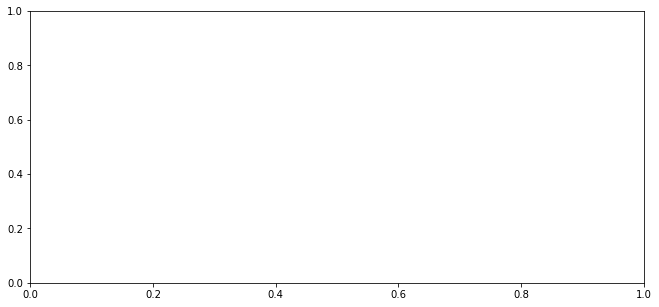

In [84]:
#total,BS = bases(50, 200, 100)
#número de UEs
max_UE = 4
N_ue = np.arange(max_UE)+1

#Calculando a capacidade de canal para UE recebendo sinal de todas as BS:
p = np.ones(max_UE)
p = p * inv_dbm(P_t)

fig, ax = plt.subplots(figsize = (11,5))
for num_ue in N_ue:
    C = np.zeros(mc)
    for k in range(mc):
        UE = usuário(num_ue, 200, 100)
        h = channel_user(N, UE, res, i)
        w = get_beamforming(h)
        SINR = sinr(h, w, j, i, σ)
        for SINRi in SINR:
            C[k] += np.log2(1+SINRi.mean())
    C = np.sort(C)# / num_ue
    average_C = np.mean(C)
    std_C = np.std(C)
    cdf_C = norm.cdf(C, loc=average_C, scale=std_C)
    
    label = ('{} users'.format(num_ue))
    ax.plot(C, cdf_C, label=label)
    print('Average Channel Capacity for {} users: {} bits/Hz'.format(num_ue, average_C))
ax.set_ylabel("CDF")
ax.set_xlabel("Channel Capacity [bits/Hz]")
plt.legend()

In [10]:
n_ue = 4
p = np.ones(n_ue)
p = p * inv_db(P_t)
UE = usuário(n_ue, 200, 100)
SINR = compute_sinr(N, UE, BS, p, n_stream)
print('SINR: {}'.format(SINR))
SINR_mean = SINR[0].mean()
print('SINRmean: {}'.format(SINR_mean))

SINR: [[0.53878442 1.30153095 0.62102836]
 [0.62546247 0.72921625 1.00310427]
 [0.68964899 1.04231687 0.69224802]
 [0.7052931  0.70038512 0.51387591]]
SINRmean: 0.820447907679085
